In [1]:
import os
import sys
data_folder = os.path.join(os.path.expanduser("~"), "ANACONDA DM", "chapter9")

In [2]:
'''
!load DM chapter_downloaddata.py
#因为，已经提前下好数据，不用再下载了
'''

'\n!load DM chapter_downloaddata.py\n#因为，已经提前下好数据，不用再下载了\n'

In [3]:
def clean_book(document):
    lines = document.split("\n")
    start = 0
    end = len(lines)
    for i in range(len(lines)):
        line = lines[i]
        if line.startswith("*** START OF THIS PROJECT GUTENBERG"):
            start = i + 1
        elif line.startswith("*** END OF THIS PROJECT GUTENBERG"):
            end = i - 1
    return "\n".join(lines[start:end])

In [4]:
import numpy as np
def load_books_data(folder=data_folder):
    documents = []
    authors = []
    subfolders = [subfolder for subfolder in os.listdir(folder) if os.path.isdir(os.path.join(folder, subfolder))]
    for author_number, subfolder in enumerate(subfolders):
        full_subfolder_path = os.path.join(folder, subfolder)
        for document_name in os.listdir(full_subfolder_path):
            with open(os.path.join(full_subfolder_path, document_name), encoding='utf-8', errors='ignore') as inf:
                #, 'rb': a bytes-like object is required, not 'str'  in lines
                #, encoding='utf-8'：'utf-8' codec can't decode byte 0xba in position 31875: invalid start byte
                #, encoding='ANSI'：'mbcs' codec can't decode bytes in position 0--1: No mapping for the Unicode character exists in the target code page.
                documents.append(clean_book(inf.read()))
                authors.append(author_number)
    return documents, np.array(authors, dtype='int')
documents, classes = load_books_data(data_folder)

In [5]:
#  功能词
function_words = ["a", "able", "aboard", "about", "above", "absent",
"according" , "accordingly", "across", "after", "against",
"ahead", "albeit", "all", "along", "alongside", "although",
"am", "amid", "amidst", "among", "amongst", "amount", "an",
"and", "another", "anti", "any", "anybody", "anyone",
"anything", "are", "around", "as", "aside", "astraddle",
"astride", "at", "away", "bar", "barring", "be", "because",
"been", "before", "behind", "being", "below", "beneath",
"beside", "besides", "better", "between", "beyond", "bit",
"both", "but", "by", "can", "certain", "circa", "close",
"concerning", "consequently", "considering", "could",
"couple", "dare", "deal", "despite", "down", "due", "during",
"each", "eight", "eighth", "either", "enough", "every",
"everybody", "everyone", "everything", "except", "excepting",
"excluding", "failing", "few", "fewer", "fifth", "first",
"five", "following", "for", "four", "fourth", "from", "front",
"given", "good", "great", "had", "half", "have", "he",
"heaps", "hence", "her", "hers", "herself", "him", "himself",
"his", "however", "i", "if", "in", "including", "inside",
"instead", "into", "is", "it", "its", "itself", "keeping",
"lack", "less", "like", "little", "loads", "lots", "majority",
"many", "masses", "may", "me", "might", "mine", "minority",
"minus", "more", "most", "much", "must", "my", "myself",
"near", "need", "neither", "nevertheless", "next", "nine",
"ninth", "no", "nobody", "none", "nor", "nothing",
"notwithstanding", "number", "numbers", "of", "off", "on",
"once", "one", "onto", "opposite", "or", "other", "ought",
"our", "ours", "ourselves", "out", "outside", "over", "part",
"past", "pending", "per", "pertaining", "place", "plenty",
"plethora", "plus", "quantities", "quantity", "quarter",
"regarding", "remainder", "respecting", "rest", "round",
"save", "saving", "second", "seven", "seventh", "several",
"shall", "she", "should", "similar", "since", "six", "sixth",
"so", "some", "somebody", "someone", "something", "spite",
"such", "ten", "tenth", "than", "thanks", "that", "the",
"their", "theirs", "them", "themselves", "then", "thence",
"therefore", "these", "they", "third", "this", "those",
"though", "three", "through", "throughout", "thru", "thus",
"till", "time", "to", "tons", "top", "toward", "towards",
"two", "under", "underneath", "unless", "unlike", "until",
"unto", "up", "upon", "us", "used", "various", "versus",
"via", "view", "wanting", "was", "we", "were", "what",
"whatever", "when", "whenever", "where", "whereas",
"wherever", "whether", "which", "whichever", "while",
"whilst", "who", "whoever", "whole", "whom", "whomever",
"whose", "will", "with", "within", "without", "would", "yet",
"you", "your", "yours", "yourself", "yourselves"]
from sklearn.feature_extraction.text import CountVectorizer
extractor = CountVectorizer(vocabulary=function_words)

In [7]:
#用N元语法分类
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import grid_search
from sklearn.metrics import classification_report

parameters = {'kernel':('linear', 'rbf'), 
              'C':[1, 10]}
svr = SVC()
grid = GridSearchCV(svr, parameters)
pipeline1 = Pipeline([('feature_extraction', extractor), ('clf', grid)])
scores = cross_val_score(pipeline1, documents, classes, scoring='f1_weighted')
print('score: {:.3f}'.format(np.mean(scores)))

score: 0.795


In [8]:
#用N元语法分类
pipeline = Pipeline([('feature_extraction', CountVectorizer(analyzer='char', ngram_range=(3, 3))), ('classifier', grid)])
scores = cross_val_score(pipeline, documents, classes, scoring='f1_weighted')
print("Score: {:.3f}".format(np.mean(scores)))

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.833


In [9]:
# 安然公司邮件数据
#enron_data_folder = os.path.join(os.path.expanduser("~"), "Data", "enron_mail_20110402", "maildir")
enron_data_folder = 'D:/Downloads/enron_mail_20150507'
from email.parser import Parser
p = Parser()
from sklearn.utils import check_random_state
def get_enron_corpus(num_authors=10, data_folder=data_folder, min_docs_author=10, max_docs_author=100, random_state=None):
    random_state = check_random_state(random_state)
    '''因为os.listdir返回的目录每次不一定相同，所以要排序'''
    email_addresses = sorted(os.listdir(data_folder))
    random_state.shuffle(email_addresses)
    documents = []
    classes = []
    author_num = 0
    authors = {}
    for user in email_addresses:
        users_email_folder = os.path.join(data_folder, user) #每个人的文件夹地址
        mail_folders = [os.path.join(users_email_folder, subfolder) for subfolder in os.listdir(users_email_folder) if "sent" in subfolder]
        # 每个人的发件箱地址，是个list，难道有过个发件箱？文件家中确实含有多个含sent的文件夹
        try:
            authored_emails = [open(os.path.join(mail_folder, email_filename), encoding='cp1252').read()
                               for mail_folder in mail_folders for email_filename in os.listdir(mail_folder)]
            # 尝试读取每封邮件，list
        except IsADirectoryError:
            # 如果sent文件夹中还有文件夹就跳过
            continue
        if len(authored_emails) < min_docs_author:
            continue
        if len(authored_emails) > max_docs_author:
            authored_emails = authored_emails[:max_docs_author]
        '''去除邮件开头部分，提取邮件内容，parsestr(text, headersonly=False)，没有找到._payload'''
        contents = [p.parsestr(email)._payload for email in authored_emails]
        documents.extend(contents)
        classes.extend([author_num] * len(authored_emails))
        authors[user] = author_num
        author_num += 1
        if author_num >= num_authors or author_num >=len(email_addresses):
            break
    return documents, np.array(classes), authors
documents, classes, authors = get_enron_corpus(data_folder=enron_data_folder, random_state=14)

In [11]:
import quotequail
def remove_replies(email_contents): #除去被回复的邮件
    r = quotequail.unwrap(email_contents) # a dictionary is returned
    if r is None:
        return email_contents
    if 'text_top' in r:
        return r['text_top']
    elif 'text' in r:
        return r['text']
    return email_contents
documents = [remove_replies(document) for document in documents]

In [12]:
scores = cross_val_score(pipeline, documents, classes, scoring='f1_weighted')
print("Score: {:.3f}".format(np.mean(scores)))

Score: 0.521


In [13]:
#  评估
from sklearn.model_selection import train_test_split
training_documents, testing_documents, y_train, y_test = train_test_split(documents, classes, random_state=14)
pipeline.fit(training_documents, y_train)
y_pred = pipeline.predict(testing_documents)
print(pipeline.named_steps['classifier'].best_params_)

{'C': 1, 'kernel': 'linear'}


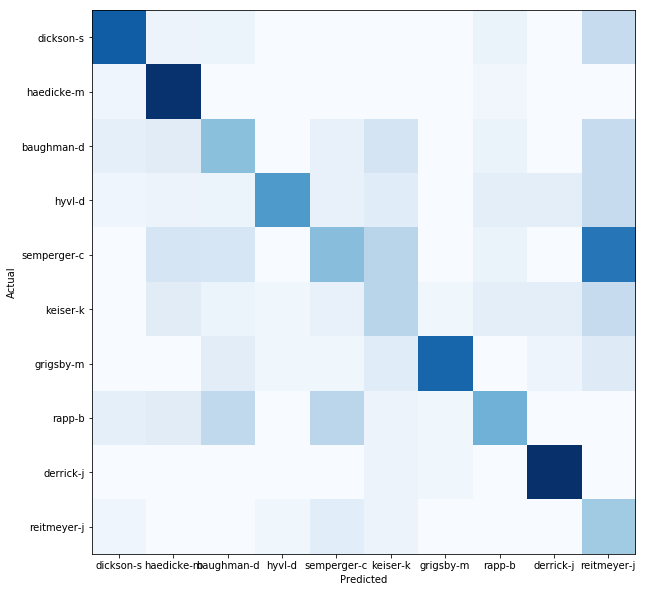

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, y_test)
cm = cm / cm.astype(np.float).sum(axis=1)
sorted_authors = sorted(authors.keys(), key=lambda x:authors[x])
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap='Blues')
tick_marks = np.arange(len(sorted_authors))
plt.xticks(tick_marks, sorted_authors)
plt.yticks(tick_marks, sorted_authors)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()